In [1]:
! pip install -U sentence-transformers
! pip install -U pyaml
! pip install -U flair
! pip install -U vaderSentiment
! pip install -U textblob
! pip install -U urllib3

  Using cached urllib3-1.26.18-py2.py3-none-any.whl (143 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.1.0
    Uninstalling urllib3-2.1.0:
      Successfully uninstalled urllib3-2.1.0
  Using cached urllib3-2.1.0-py3-none-any.whl (104 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
botocore 1.34.23 requires urllib3<2.1,>=1.25.4; python_version >= "3.10", but you have urllib3 2.1.0 which is incompatible.
flair 0.13.1 requires urllib3<2.0.0,>=1.0.0, but you have urllib3 2.1.0 which is incompatible.


In [2]:
! git clone https://github.com/Guilherme26/dissertation.git

fatal: destination path 'dissertation' already exists and is not an empty directory.


In [3]:
from statsmodels.distributions import ECDF
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml

In [4]:
from flair.models import TextClassifier as FlairModel
from flair.data import Sentence as FlairSentence

from textblob import TextBlob

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as Vader

In [5]:
def text_blob_score(txt):
    return TextBlob(txt).sentiment.polarity

vader = Vader()
def vader_score(txt):
    global vader
    pol = vader.polarity_scores(txt)
    neg = pol["neg"]
    return neg

def flair_score(txt):
    classifier = FlairModel.load('en-sentiment')
    sentence = FlairSentence(txt)
    classifier.predict(sentence)

    if sentence.labels[0]._value == 'NEGATIVE':
        return -sentence.labels[0]._score
    else:
        return sentence.labels[0]._score

def flair_score_all(df):
    classifier = FlairModel.load('en-sentiment')
    sentences = [x for x in df['text'].apply(FlairSentence).values]
    classifier.predict(sentences)

    return pd.Series(
        list(
            map(lambda s: s.score if s.labels[0]._value[0] == 'P' else -s.score,
                sentences
            )
        ), index=df.index
    )

    return sentences

In [6]:
# 3.3 polegadas de largura, 1.65 * isso (golden ratio) altura
plt.rcParams['figure.figsize'] = (3.3, 3.3  / 1.65)

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['font.family'] = 'serif'

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linewidth'] = .1

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['legend.fontsize'] = 10

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 5

In [7]:
plt.style.use('tableau-colorblind10')
plt.ion();

In [8]:
! mkdir dissertation/data/04_scored/cb
! cp dissertation/data/04_scored/coraal/* dissertation/data/04_scored/cb
! cp dissertation/data/04_scored/buckeye/* dissertation/data/04_scored/cb

mkdir: cannot create directory ‘dissertation/data/04_scored/cb’: File exists


In [9]:
import re

with open('dissertation/data/aae_terms_black_talk.yaml') as f:
    aae_t = yaml.safe_load(f)['terms']

aae_t = set(
    map(lambda s: s.
        replace(r"[^\w\d'\s]+", '').
        lower(),
        aae_t
    )
)

def count_aae(txt):
    return sum(
        map(lambda s: s in aae_t, txt.split())
    )

In [10]:
import os

def load_df(fold):
    if os.path.exists(f'{fold}.csv'):
        df = pd.read_csv(f'{fold}.csv').iloc[:, 1:]
        return df
    else:
        files = Path(f'dissertation/data/04_scored/{fold}').glob('*')

        dfs = []
        for f in files:
            data = pd.read_csv(f)
            data['file'] = f.stem
            dfs.append(data)

        df = pd.concat(dfs, ignore_index=True)

        df['textblob_score'] = df['text'].apply(text_blob_score)
        df['vader_score'] = df['text'].apply(vader_score)
        df['flair_score'] = flair_score_all(df)

        df['text'] = (
            df['text'].str.lower().
            str.replace(r"[^\w\d'\s]+", '', regex=True)
        )
        df = df.dropna()

        # df['aae_count'] = df['text'].str.count(r'|'.join(aae_t))
        df['aae_count'] = df['text'].apply(count_aae)
        df = df.sort_index()
        df.to_csv(f'{fold}.csv')
        return df

In [35]:
def cdf_plots(df):
    fig, axes = plt.subplots(1, 6, figsize=(20, 3))
    i = 0
    for scorer in ['textblob_score',
                   'flair_score',
                   'vader_score',
                   'perspective_score',
                   'detoxify_original_score',
                   'detoxify_unbiased_score']:
        aae_cnt = df['aae_count']

        ax = axes[i]

        cm = plt.get_cmap('tab20c').colors
        sub = df[aae_cnt == 0]
        scores = sub[scorer]
        ecdf = ECDF(scores.values)
        ax.plot(ecdf.x, 1-ecdf.y, label='0 AAE Expr.', lw=1.5, color=cm[6])

        color = 15
        if fold == 'twitter':
            ks = [1, 3, 5]
        else:
            ks = [1, 3, 5, 7]
        for k in ks:
            sub = df[aae_cnt >= k]
            scores = sub[scorer]

            ecdf = ECDF(scores.values)
            ax.plot(ecdf.x, 1-ecdf.y, label=f'{k} or more', lw=1.5, color=cm[color])
            color = color - 1

        if i != 0:
            ax.tick_params(left = False)
            ax.yaxis.set_ticklabels([])
        else:
            ax.set(ylabel=r'$P[X \geq x]$')

        if scorer == 'textblob_score':
            ax.set(title='Textblob (L)', xlabel='x - Polarity')
            ax.set(xlim=(-1, 1))
            ax.vlines(0, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.1, 0.5, '➡ Positive Sent.', fontsize=8)
            ax.text(-0.8, 0.5, 'Negative Sent. ⬅', fontsize=8)
            ax.text(-0.98, 0.02, '↙ Majority of uttr\nare negative', fontsize=8)
            ax.text(0.30, 0.90, '↗ Majority of uttr\nare positive', fontsize=8)

        if scorer == 'flair_score':
            ax.set(title='Flair (ML)', xlabel='x - Polarity')
            ax.set(xlim=(-1, 1))
            ax.vlines(0, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.1, 0.5, '➡ Positive Sent.', fontsize=8)
            ax.text(-0.8, 0.5, 'Negative Sent. ⬅', fontsize=8)
            ax.text(-0.98, 0.02, '↙ Majority of uttr\nare negative', fontsize=8)
            ax.text(0.30, 0.90, '↗ Majority of uttr\nare positive', fontsize=8)

        if scorer == 'vader_score':
            ax.legend(loc='center right')
            ax.set(title='Vader (L)', xlabel='x - Neg. Probability')
            ax.set(xlim=(0, 1))
            ax.text(0.22, 0.45, 'Bias more\npresent\nbefore 0.20\nprob.', fontsize=8)
            ax.vlines(0.2, 0, 1, lw=1, ls='--', color='k', zorder=1)
            # ax.text(0.01, 0.02, '↙ Majority of uttr\nare not neg.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nare neg.', fontsize=8)

        if scorer == 'detoxify_original_score':
            ax.set(title='Detoxify (ML)', xlabel='x - Toxic Probability')
            ax.set(xlim=(0, 1))
            ax.vlines(0.55, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.56, 0.5, 'Cut-off suggested by: \nMuralikumar et al.\n2023', fontsize=8)
            # ax.text(0.01, 0.30, '↙ Majority of uttr\nhave low scores.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nhave high scores.', fontsize=8)

        if scorer == 'detoxify_unbiased_score':
            ax.set(title='Detoxify Unbiased (ML)', xlabel='x - Toxic Probability')
            ax.set(xlim=(0, 1))
            ax.vlines(0.55, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.56, 0.5, 'Cut-off suggested by: \nMuralikumar et al.\n2023', fontsize=8)
            # ax.text(0.01, 0.30, '↙ Majority of uttr\nhave low scores.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nhave high scores.', fontsize=8)

        if scorer == 'perspective_score':
            ax.set(title='Perspective (ML)', xlabel='x - Toxic Probability')
            ax.set(xlim=(0, 1))
            ax.vlines(0.55, 0, 1, lw=1, ls='--', color='k', zorder=1)
            ax.text(0.56, 0.5, 'Cut-off suggested by: \nMuralikumar et al.\n2023', fontsize=8)
            # ax.text(0.15, 0.30, '↙ Majority of uttr\nhave low scores.', fontsize=8)
            ax.text(0.65, 0.90, '↗ Majority of uttr\nhave high scores.', fontsize=8)
        ax.set(ylim=(0, 1))
        i += 1
    fig.tight_layout(pad=0)
    # plt.show()
    plt.savefig(f'{fold}.pdf', bbox_inches = 'tight')

## Cumulative Distribution Functions

,text,perspective_score,flair_score,textblob_score,vader_score,detoxify_original_score,detoxify_unbiased_score,detoxify_multilingual_score,has_swearing,file,aae_count
0,sausage egg and cheese in a croissant and a me...,0.025864,0.944795,0.50,0.000,0.001259,0.001153,0.000685,False,wh_175,3
1,all my niggas off the porch and neva ina house,0.766301,-0.817008,0.00,0.211,0.971459,0.934324,0.970344,False,aa_14,2
2,user lol eating good ain't it,0.135210,0.927549,0.75,0.000,0.023361,0.003057,0.000923,False,aa_181,0
3,storybehindmyscar my bro hit me in the head wi...,0.271282,-0.928963,0.00,0.154,0.128487,0.317185,0.015971,False,wh_182,4
4,jax keeps curling up on my bed and tossing and...,0.222457,0.845173,0.00,0.000,0.046353,0.021796,0.002175,False,wh_83,1


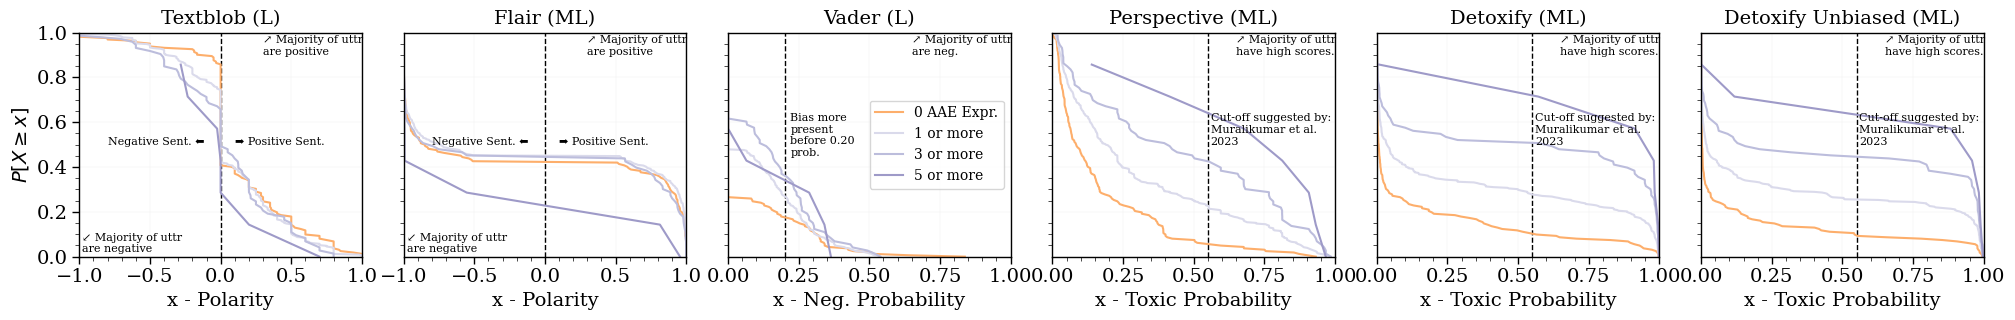

In [39]:
fold = 'twitter'
df = load_df(fold)
cdf_plots(df)
df.head()

In [13]:
from random import choice
from random import shuffle

def get_extreme_pairs(df):
    cc = []
    for scorer in [
        'textblob_score',
        'flair_score',
        'vader_score',
        'perspective_score',
        'detoxify_original_score',
        'detoxify_unbiased_score'
        ]:
        scores = df[scorer].sort_values().dropna()
        n = int(0.025 * len(df))

        if scorer in {'textblob_score', 'flair_score'}:
            top = scores[:n].index
            bottom = scores[-n:].index
        else:
            top = scores[-n:].index
            bottom = scores[:n].index

        for i in range(100000):
            t = choice(top)
            b = choice(bottom)
            cc.append((t, b))
    cc = list(set(cc))
    shuffle(cc)
    cc = cc[:1000000]
    return cc

In [14]:
def get_extreme_pairs_utter(df, ep):
    u1s = []
    u2s = []
    for row1, row2 in ep:
        u1s.append(df.loc[row1].text)
        u2s.append(df.loc[row2].text)
    return u1s, u2s

In [15]:
ep = get_extreme_pairs(df)
len(ep)

585679

In [16]:
u1s, u2s = get_extreme_pairs_utter(df, ep)

In [17]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('all-MiniLM-L6-v2')

In [18]:
embeddings1 = model.encode(u1s, convert_to_tensor=True)
embeddings2 = model.encode(u2s, convert_to_tensor=True)

In [19]:
nrm1 = ((embeddings1 ** 2).sum(dim=1) ** 0.5)
nrm2 = ((embeddings2 ** 2).sum(dim=1) ** 0.5)

In [20]:
cosine_scores = (embeddings1 * embeddings2).sum(dim=1) / (nrm1 * nrm2)

In [21]:
import torch
top_sim = torch.where(cosine_scores >= 0.5)[0].cpu()

In [22]:
diffs = []
data = []
ab05 = 0
for i in top_sim:
    top_row = df.loc[ep[i][0]]
    bottom_row = df.loc[ep[i][1]]

    u1 = top_row.text
    u2 = bottom_row.text
    # print(u1)
    # print(u2)
    sim = cosine_scores[i]
    # print(sim)

    # if sim > 0.5:
    if bottom_row.aae_count - top_row.aae_count < 0:
        for scorer in [
            'textblob_score',
            'flair_score',
            'vader_score',
            'perspective_score',
            'detoxify_original_score',
            'detoxify_unbiased_score']:
            diff = top_row[scorer] - bottom_row[scorer]
            print(scorer, diff)

        print(top_row.aae_count, u1)
        print(bottom_row.aae_count, u2)
        print()
    if bottom_row.aae_count != 0 or top_row.aae_count != 0:
        # if bottom_row.aae_count != top_row.aae_count:
        data.append(bottom_row.aae_count - top_row.aae_count)
# xs = np.array(xs)
# ys = np.array(ys)
data = np.array(data)
print(len(data))
print((data < 0).mean())
print(ab05)

textblob_score -0.6119047619047617
flair_score -1.9998306035995483
vader_score 0.049
perspective_score 0.15698589000000002
detoxify_original_score 0.0006042142049409
detoxify_unbiased_score 0.0007507253321819001
2 you know everyone can share their moment when they dozed off and a lord of the rings movie or a hobbit movie right and speaking of the hobbit this franchise that franchise ultimately became too boring to continue at least on the silver screen
1 and yes that can seem very daunting at first but i've got to be honest even though there are times in the film where you can kind of feel that three hour runtime kick in i was thoroughly fascinated and engaged throughout the entire thing and that's also even more saying something considering that a lot of the movie is just people talking

textblob_score 0.0
flair_score 0.001212596893310658
vader_score 0.535
perspective_score 0.360611575
detoxify_original_score 0.5975391643005424
detoxify_unbiased_score 0.2959725109103601
1 this movie's

In [29]:
(data < 0).sum()

272

In [30]:
(data == 0).sum()

87

In [31]:
(data > 0).sum()

209